<a href="https://colab.research.google.com/github/moye25/Prof-project--GNSS/blob/main/Salil_Goel_Project_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Rounding off the timestamp

In [2]:
import pandas as pd

# Step 1: Load CSV
df = pd.read_csv('/content/redmi_9th_april_GPS_L1_pseudorange_values.csv')

# Step 2: Preserve original timestamp column
df['Raw_Timestamp'] = df['Timestamp'].astype(str).str.strip()

# Step 3: Try initial parsing
df['Timestamp'] = pd.to_datetime(df['Raw_Timestamp'], errors='coerce')

# Step 4: Attempt fallback parsing if still NaT
# This handles timestamps with microseconds if format is known
mask_invalid = df['Timestamp'].isna()
if mask_invalid.any():
    df.loc[mask_invalid, 'Timestamp'] = pd.to_datetime(
        df.loc[mask_invalid, 'Raw_Timestamp'],
        format='%Y-%m-%d %H:%M:%S.%f',
        errors='coerce'
    )

# Step 5: Round to nearest second
def round_to_nearest_second(ts):
    if pd.notnull(ts):
        return (ts + pd.Timedelta(microseconds=500000)).replace(microsecond=0)
    return pd.NaT

df['Timestamp'] = df['Timestamp'].apply(round_to_nearest_second)

# Step 6: Save cleaned CSV
df.drop(columns=['Raw_Timestamp'], inplace=True)
df.to_csv('redmi_9th_april_updated_timestamps_gps_l1.csv', index=False)

# Step 7: Show status
num_invalid = df['Timestamp'].isna().sum()
print(f"✅ Done! Invalid timestamps remaining: {num_invalid}")
print(df.head(10))


FileNotFoundError: [Errno 2] No such file or directory: '/content/redmi_9th_april_GPS_L1_pseudorange_values.csv'

extracting every 30 epoc

In [3]:
import pandas as pd

# Load your CSV file
df = pd.read_csv("/content/redmi_9th_april_updated_timestamps_gps_l1.csv", parse_dates=['Timestamp'])  # replace with your actual filename and timestamp column

# Make sure the timestamp column is in datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filter rows where the seconds part is 0 or 30
filtered_df = df[df['Timestamp'].dt.second.isin([0, 30])]

# Optional: save the filtered result to a new CSV
filtered_df.to_csv("filtered_30s_intervals_redmi_gps_l1_april_9th.csv", index=False)


FileNotFoundError: [Errno 2] No such file or directory: '/content/redmi_9th_april_updated_timestamps_gps_l1.csv'

Generating skyplot

In [ ]:
!pip install odfpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the R10 observation (pseudorange) and satellite coordinates
r10_df = pd.read_csv("/content/Base_GPS_L1_9th_april_pseudorange_values.csv")
sat_df = pd.read_csv("/content/Base_GPS_L1_9th_april_satellite_coordinates.csv")

# Merge both on 'Timestamp'
merged_df = pd.merge(r10_df, sat_df, on="Timestamp")

# True ECEF coordinates of R10 receiver
receiver_ecef_r10 = np.array([968879.58937, 5628035.88713, 2830901.01396])

# Function to convert ECEF to geodetic coordinates
def ecef_to_geodetic(x, y, z):
    a = 6378137.0
    f = 1 / 298.257223563
    b = a * (1 - f)
    e2 = f * (2 - f)
    ep2 = (a**2 - b**2) / b**2
    r = np.sqrt(x**2 + y**2)
    E2 = a**2 - b**2
    F = 54 * b**2 * z**2
    G = r**2 + (1 - e2) * z**2 - e2 * E2
    c = (e2**2 * F * r**2) / G**3
    s = (1 + c + np.sqrt(c**2 + 2*c))**(1/3)
    P = F / (3 * (s + 1/s + 1)**2 * G**2)
    Q = np.sqrt(1 + 2 * e2**2 * P)
    r0 = -(P * e2 * r) / (1 + Q) + np.sqrt(
        0.5 * a**2 * (1 + 1/Q) -
        P * (1 - e2) * z**2 / (Q * (1 + Q)) -
        0.5 * P * r**2)
    U = np.sqrt((r - e2 * r0)**2 + z**2)
    V = np.sqrt((r - e2 * r0)**2 + (1 - e2) * z**2)
    Z0 = (b**2 * z) / (a * V)
    h = U * (1 - b**2 / (a * V))
    lat = np.arctan((z + ep2 * Z0) / r)
    lon = np.arctan2(y, x)
    return np.degrees(lat), np.degrees(lon), h

# Convert R10 position to geodetic
lat, lon, _ = ecef_to_geodetic(*receiver_ecef_r10)
lat_rad = np.radians(lat)
lon_rad = np.radians(lon)

# Compute ENU basis vectors
E = np.array([-np.sin(lon_rad), np.cos(lon_rad), 0])
N = np.array([-np.cos(lon_rad)*np.sin(lat_rad), -np.sin(lon_rad)*np.sin(lat_rad), np.cos(lat_rad)])
U = np.array([np.cos(lon_rad)*np.cos(lat_rad), np.sin(lon_rad)*np.cos(lat_rad), np.sin(lat_rad)])

# Determine satellite names from satellite coordinate columns
sat_names = sorted(set(col.split('_')[0] for col in sat_df.columns if '_X' in col))

# Filter only valid satellites present in both pseudorange and coordinate data
valid_sat_names = [
    name for name in sat_names
    if name in r10_df.columns and all(f"{name}_{axis}" in sat_df.columns for axis in ['X', 'Y', 'Z'])
]

# Color map and containers
color_map = plt.cm.get_cmap('tab20', len(valid_sat_names))
sat_colors = {name: color_map(i) for i, name in enumerate(valid_sat_names)}
sat_az_el = {name: {'az': [], 'el': []} for name in valid_sat_names}

# Compute azimuth and elevation
for name in valid_sat_names:
    pr_mask = r10_df[name].notna().values
    sat_xyz = merged_df[[f"{name}_X", f"{name}_Y", f"{name}_Z"]].values
    for i, xyz in enumerate(sat_xyz):
        if np.all(xyz != 0.0) and pr_mask[i]:
            vec = xyz - receiver_ecef_r10
            vec_norm = vec / np.linalg.norm(vec)
            el = np.arcsin(np.dot(vec_norm, U))
            az = np.arctan2(np.dot(vec_norm, E), np.dot(vec_norm, N)) % (2 * np.pi)
            if np.degrees(el) > 0:  # Ignore satellites below horizon
                sat_az_el[name]['az'].append(az)
                sat_az_el[name]['el'].append(np.degrees(el))  # Use elevation directly

# Plot skyplot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, polar=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_ylim(90, 0)  # Zenith (90°) at center, horizon (0°) at edge

for name in valid_sat_names:
    az = sat_az_el[name]['az']
    el = sat_az_el[name]['el']
    if az:  # Only plot if data is available
        ax.scatter(az, el, s=10, color=sat_colors[name], label=name)

ax.set_title("Skyplot for GPS L1")
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.05), fontsize='x-small', ncol=2)
plt.tight_layout()
plt.savefig("Skyplot_Base_L1_TruePos_April_5th.png", dpi=300)
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for odfpy: filename=odfpy-1.4.1-py2.py3-none-any.whl size=160673 sha256=8c6ec15cc1f6db6ca415ea8b2c33b81fc9924166f4caaaedaf87152b35816b6f
  Stored in directory: /root/.cache/pip/wheels/d6/1d/c8/8c29be1d73ca42d15977c75193d9f39a98499413c2838ac54c
Successfully built odfpy


FileNotFoundError: [Errno 2] No such file or directory: '/content/Base_GPS_L1_9th_april_pseudorange_values.csv'

After generating the Reference satellite we have to do the double differencing wrt Base_staion taking the satellite at highest elevation as reference

In [ ]:
!pip install odfpy
import pandas as pd

# Load your CSV file that contains all the pseudiranges from all the receivers (column headings: Base:sat_PR_BS; Receiver:sat_PR_receiver)
df = pd.read_csv('/content/Data_for_double_differencing_9th_April.csv')

# List of receivers
receivers = ['SAMSUNG', 'REDMI']  # Example list of receivers

# Reference satellite (G30) considered from the skyplot
ref_sat = 'G32'

# Output DataFrame to collect results
output_all = pd.DataFrame()
output_all['Epoch'] = df['Epoch'] if 'Epoch' in df.columns else df.index

# Include timestamp in the output
if 'Timestamp' in df.columns:
    output_all['Timestamp'] = df['Timestamp']

# Iterate over each receiver
for receiver in receivers:
    print(f"Processing receiver: {receiver}")

    # Compute single differences (SD) for each satellite(common satellites taken from observing the skyplots)
    for sat in ['G18', 'G10', 'G15', 'G23', 'G24','G25','G27', 'G29', 'G32']:  # List of satellites
        base_col = f'{sat}_PR_BS'
        recv_col = f'{sat}_PR_{receiver}'

        # Check if the necessary columns exist in the DataFrame before proceeding
        if base_col in df.columns and recv_col in df.columns:
            sd_col_name = f'SD_PR_BS_{receiver}_{sat}'
            df[sd_col_name] = df[base_col] - df[recv_col]
        else:
            print(f"Skipping {sat} for {receiver}: Required columns not found.")

    # Compute double differences (DD) using the reference satellite (G18) and another satellite
    for sat in ['G18', 'G10', 'G15', 'G23', 'G24','G25','G27', 'G29']:  # Exclude the reference satellite G18
        sd_col_name_ref = f'SD_PR_BS_{receiver}_{ref_sat}'
        sd_col_name_sat = f'SD_PR_BS_{receiver}_{sat}'

        # Check if both single difference columns exist before computing double difference
        if sd_col_name_ref in df.columns and sd_col_name_sat in df.columns:
            dd_col_name = f'DD_PR_DIFF_BS_{receiver}_{ref_sat}_{sat}'
            df[dd_col_name] = df[sd_col_name_ref] - df[sd_col_name_sat]
        else:
            print(f"Skipping double difference for {ref_sat} and {sat} and {receiver}: SD columns not found.")

    # Append receiver results to output DataFrame
    for col in df.columns:
        if col.startswith(f'SD_PR_BS_{receiver}') or col.startswith(f'DD_PR_DIFF_BS_{receiver}'):
            output_all[col] = df[col]

# Save the full DataFrame with SD/DD results to a CSV file
output_all.to_csv('DD_GENERATED_GPS_L1_ALL_RECEIVERS.csv', index=False)
print("\n✅ Results saved to 'FINAL_BS_All_Receivers_DD_GPS_L1.csv'")


Processing receiver: SAMSUNG
Processing receiver: REDMI

✅ Results saved to 'FINAL_BS_All_Receivers_DD_GPS_L1.csv'


Double Difference plots wrt Timestamps for all receivers

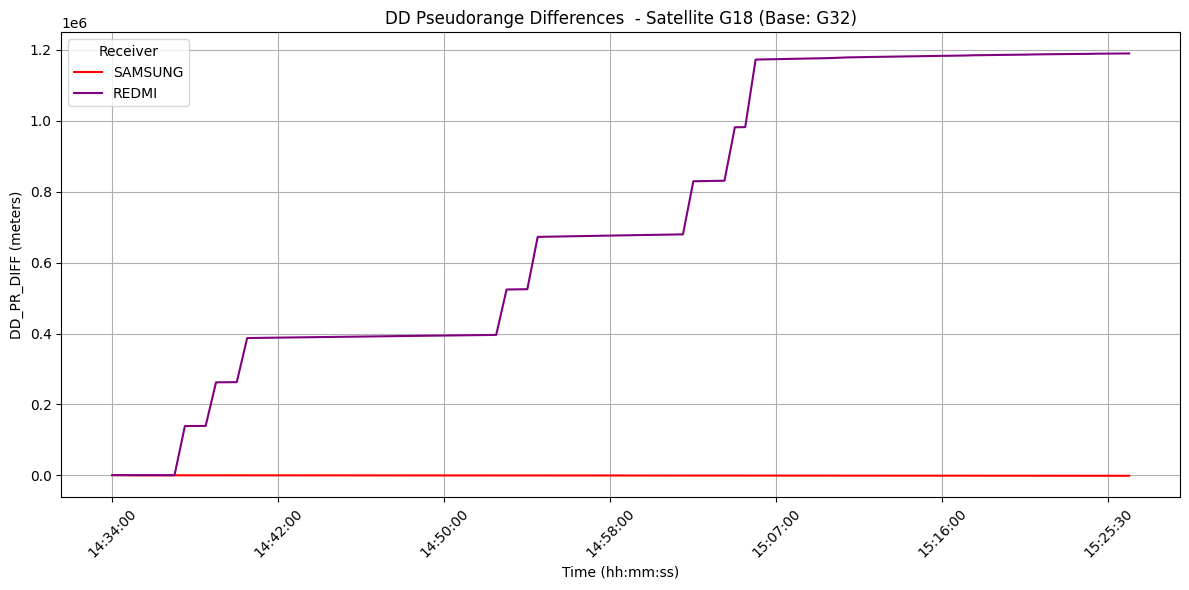

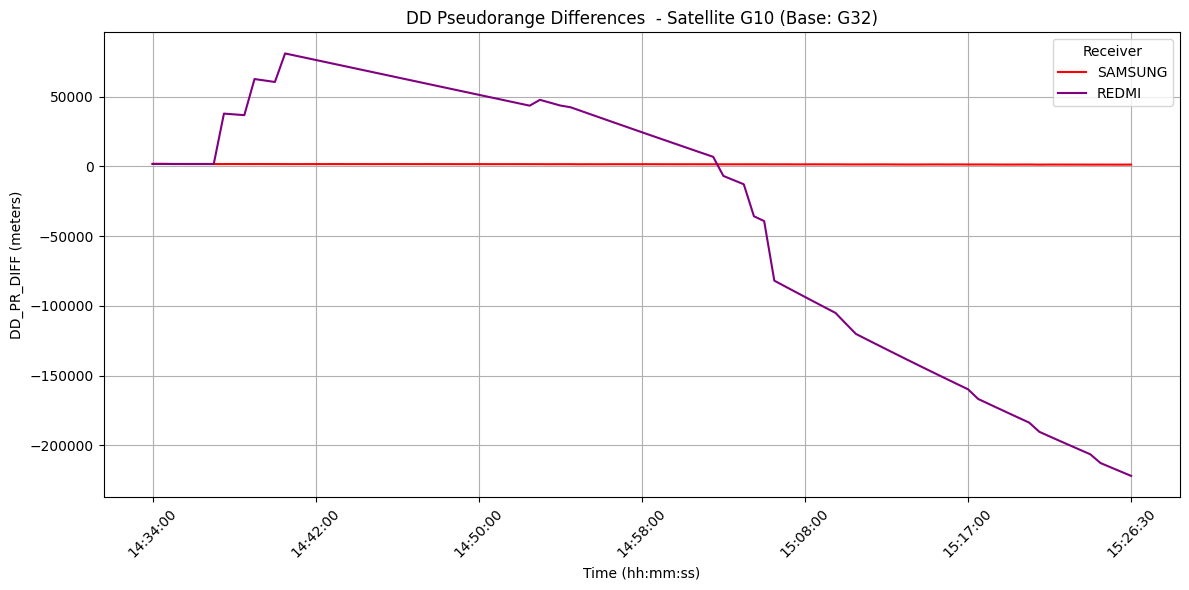

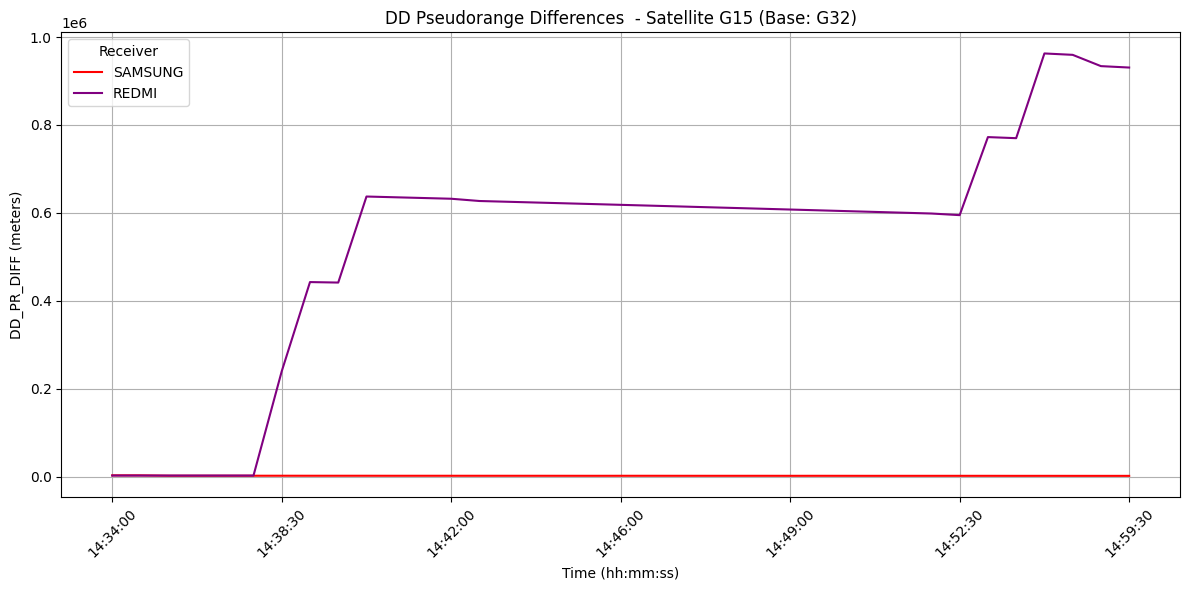

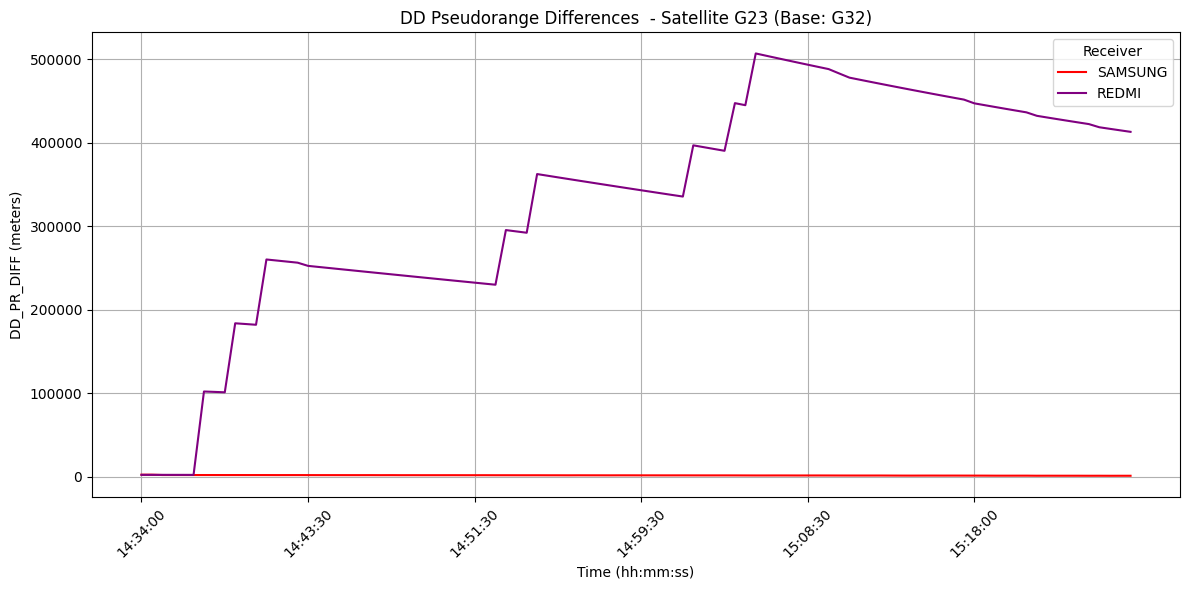

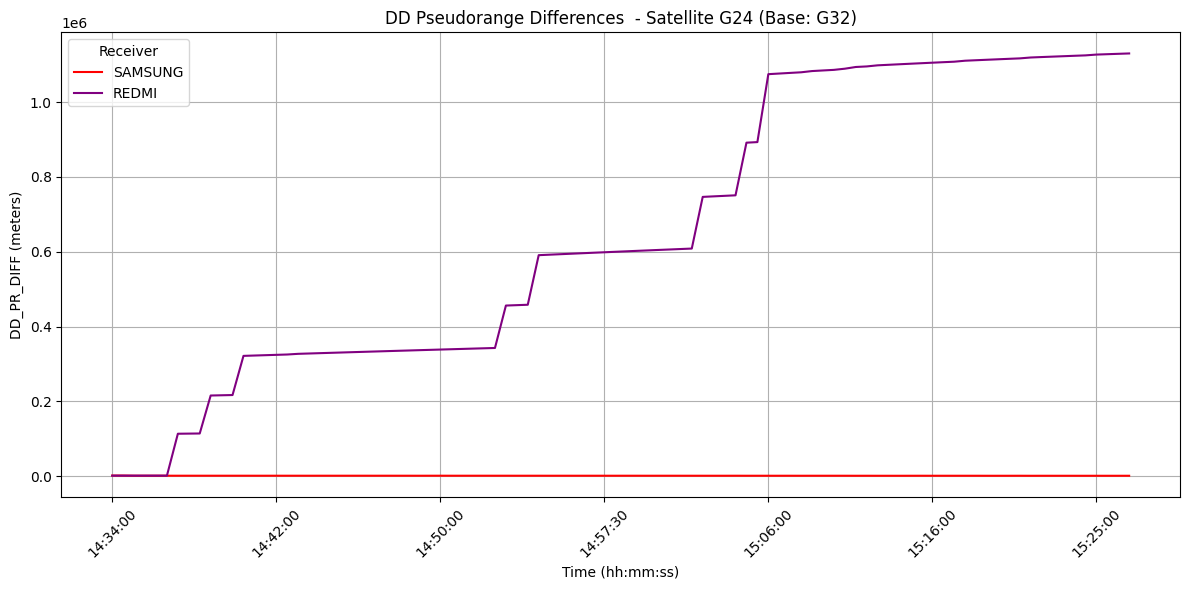

No complete data for Satellite G25 — skipping plot.


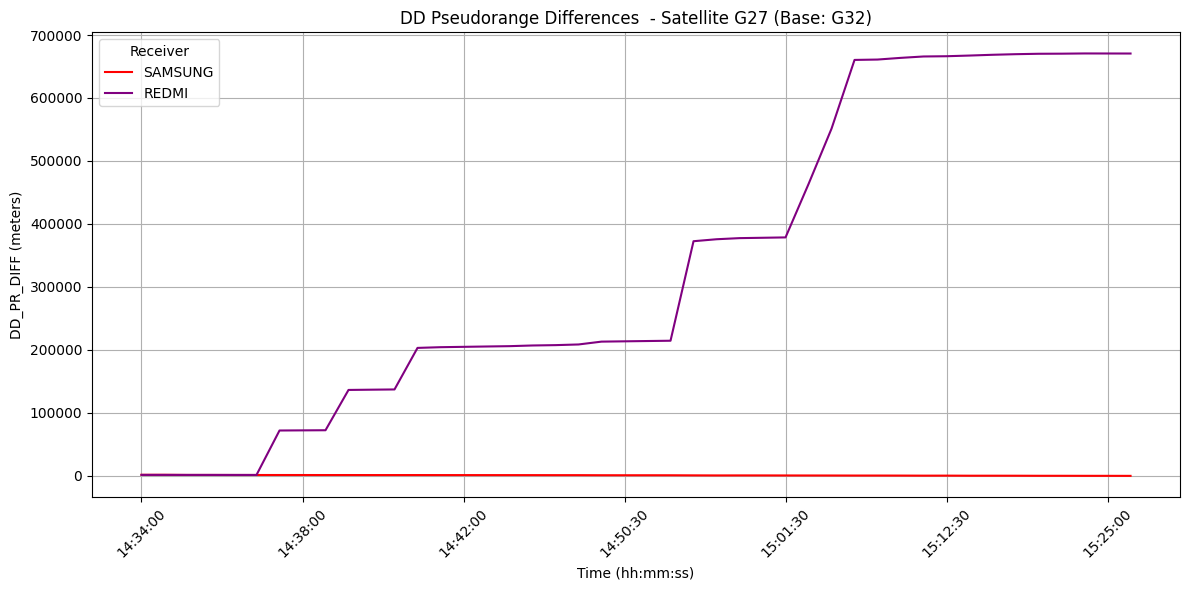

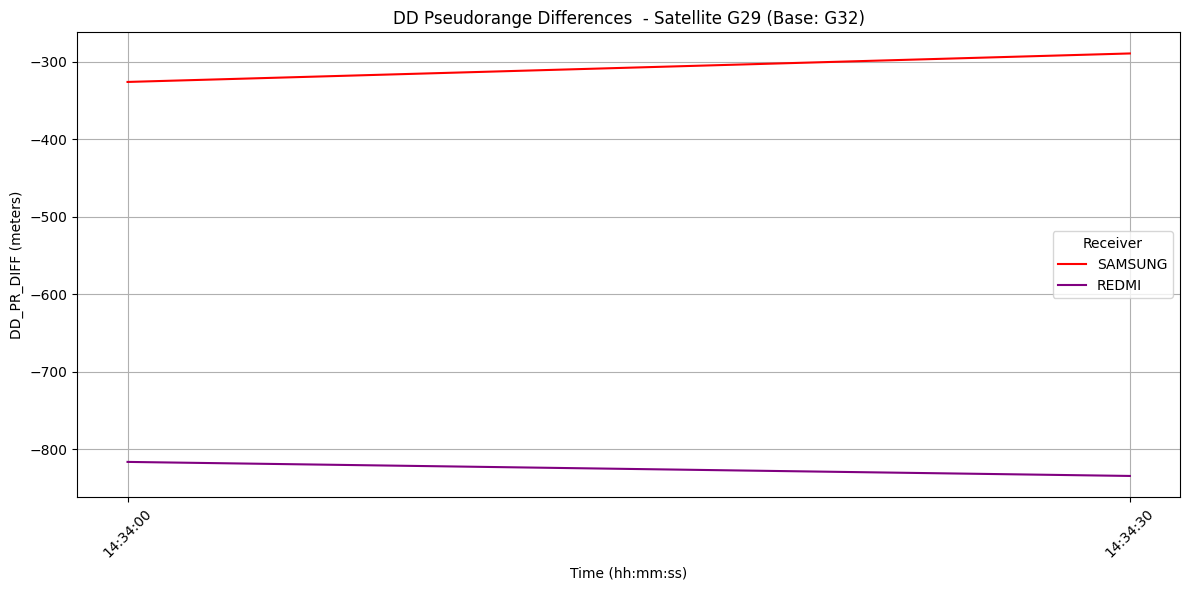

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
file_path = '/content/DD_GENERATED_GPS_L1_ALL_RECEIVERS.csv'
df = pd.read_csv(file_path)

# Epoch column
epoch_col = 'Epoch'

# Devices and satellites
devices = ['SAMSUNG', 'REDMI']  # REALME excluded as the data was not collected properly due to overheating
common_sat = 'G32'   #Reference satellite
secondary_sats = ['G18', 'G10', 'G15', 'G23', 'G24','G25','G27', 'G29']    #Common satellites

# ✅ Device to color mapping
receiver_colors = {                      #change according to your receivers
    'BS': 'black',
    'REDMI': 'purple',
    'SAMSUNG': 'red',

}

# Plotting loop
for sat in secondary_sats:
    # Columns needed for this satellite
    cols = [f'DD_PR_DIFF_BS_{dev}_{common_sat}_{sat}' for dev in devices]
    available_cols = [col for col in cols if col in df.columns]

    # Filter out rows with any NaNs in these columns
    filtered_df = df[['Timestamp', epoch_col] + available_cols].dropna()

    # Plot if there's data
    if not filtered_df.empty:
        plt.figure(figsize=(12, 6))

        # Convert Timestamp to datetime and extract only time part
        filtered_df['Timestamp'] = pd.to_datetime(filtered_df['Timestamp'])
        filtered_df['Time'] = filtered_df['Timestamp'].dt.strftime('%H:%M:%S')

        for dev in devices:
            col_name = f'DD_PR_DIFF_BS_{dev}_{common_sat}_{sat}'
            if col_name in filtered_df.columns:
                color = receiver_colors.get(dev, 'gray')  # fallback color
                plt.plot(filtered_df['Time'], filtered_df[col_name], label=dev, color=color)

        plt.title(f'DD Pseudorange Differences  - Satellite {sat} (Base: {common_sat})')
        plt.xlabel('Time (hh:mm:ss)')
        plt.ylabel('DD_PR_DIFF (meters)')
        plt.legend(title='Receiver')
        plt.grid(True)

        # Limit x-axis ticks to every 5th or 6th time point
        num_ticks = len(filtered_df['Time'])
        tick_positions = range(0, num_ticks, max(1, num_ticks // 6))  # Show up to 6 ticks

        plt.xticks(tick_positions, filtered_df['Time'].iloc[tick_positions], rotation=45)  # Rotate for readability
        plt.tight_layout()
        plt.show()
    else:
        print(f"No complete data for Satellite {sat} — skipping plot.")


SNR plots

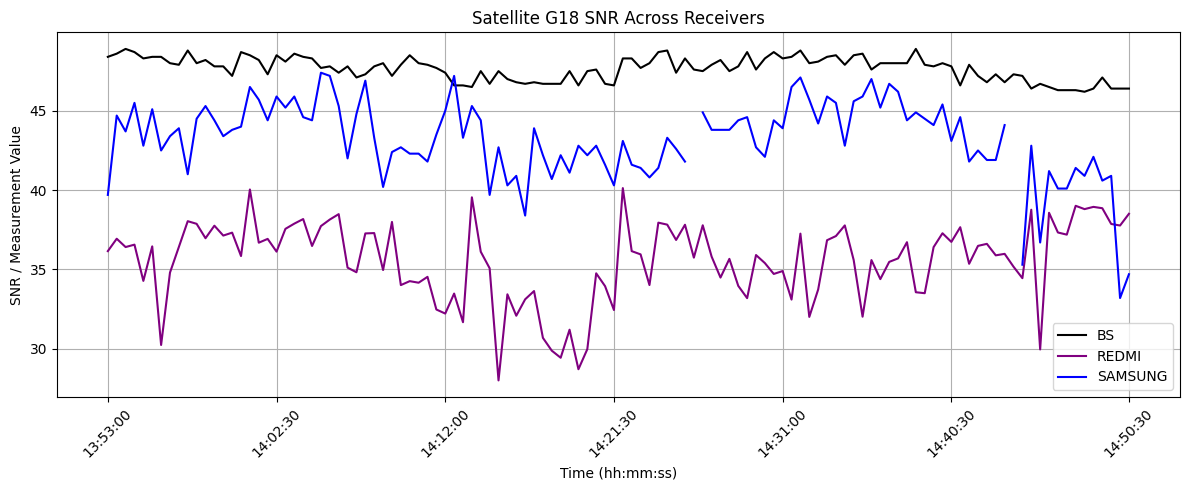

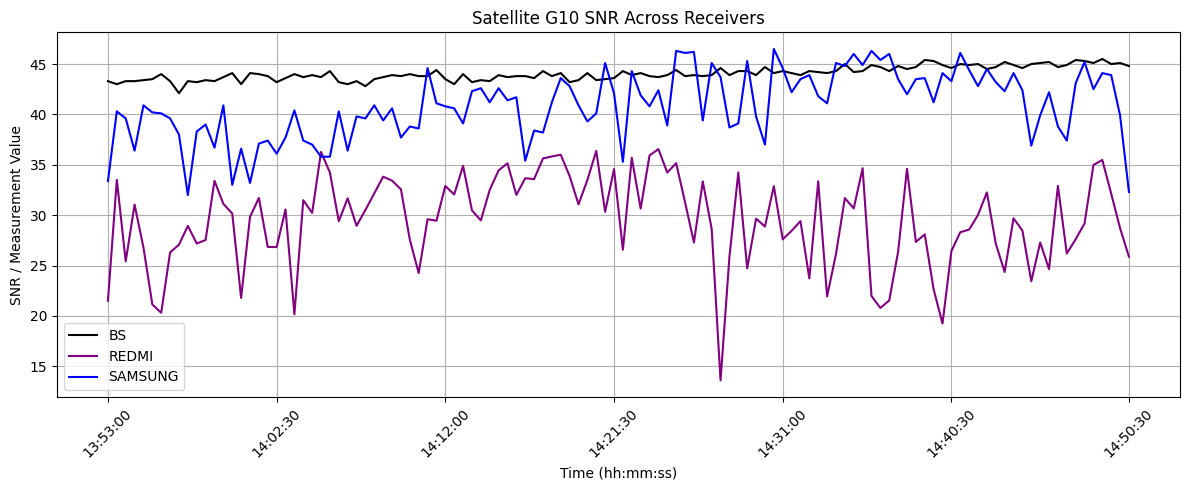

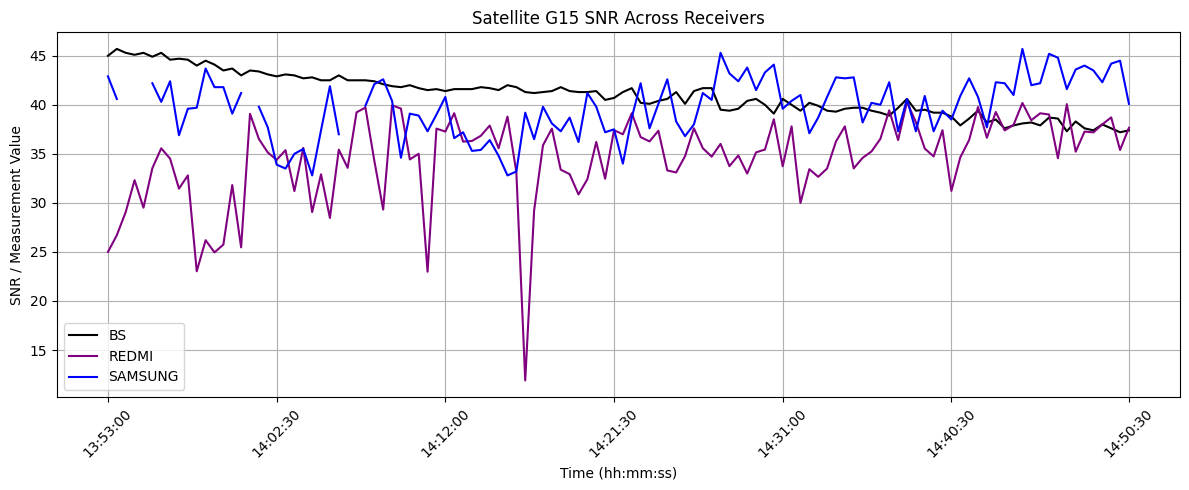

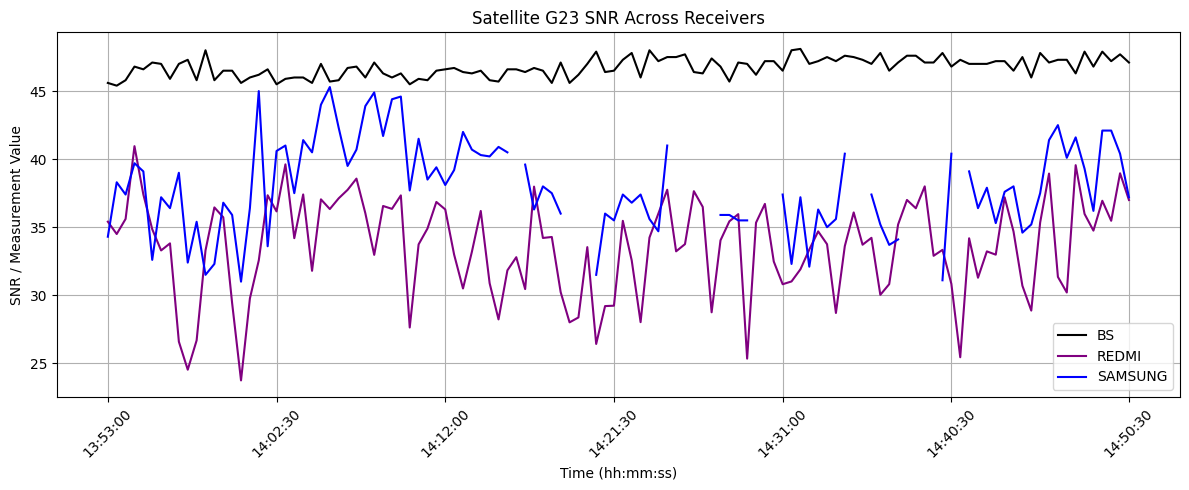

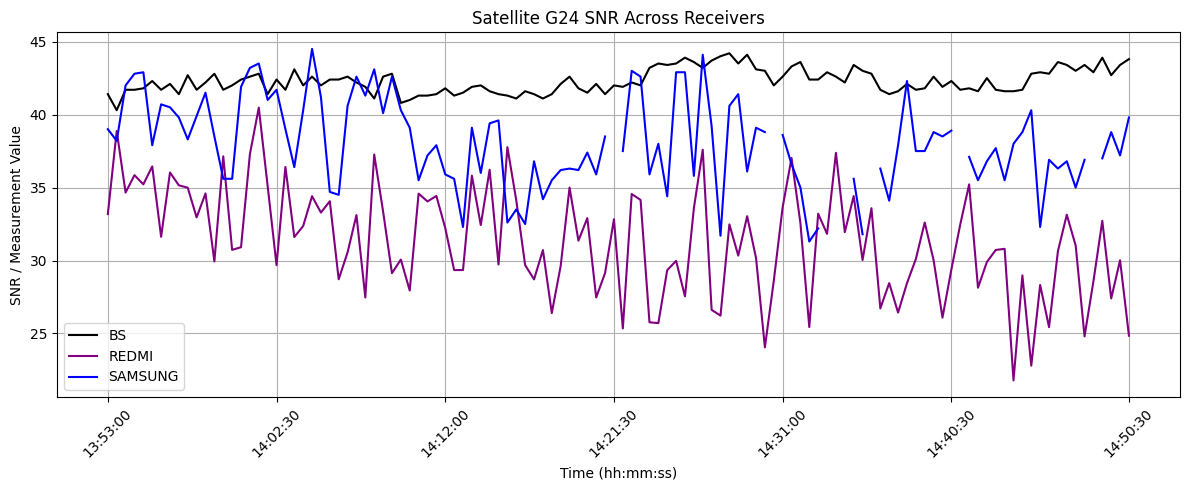

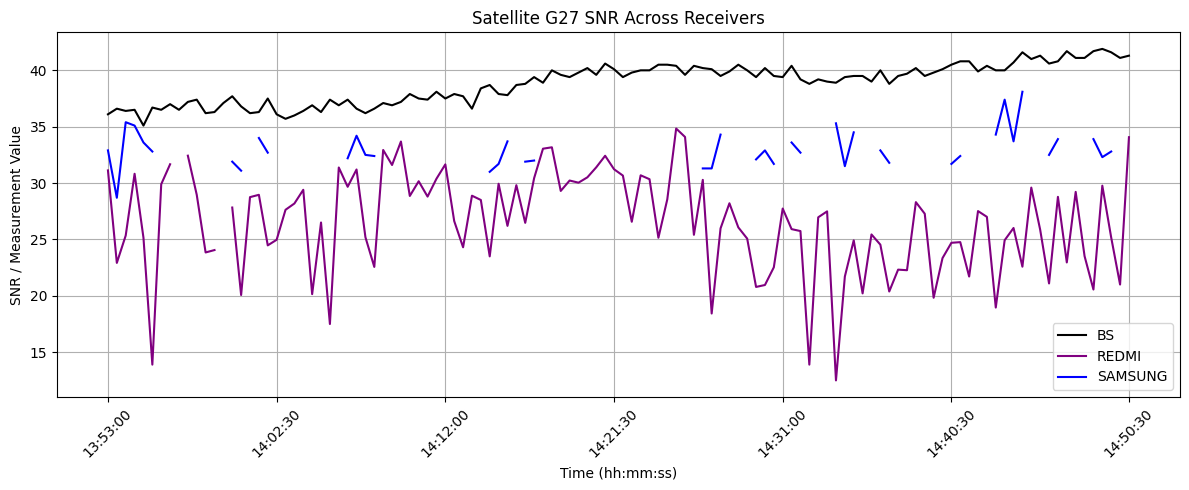

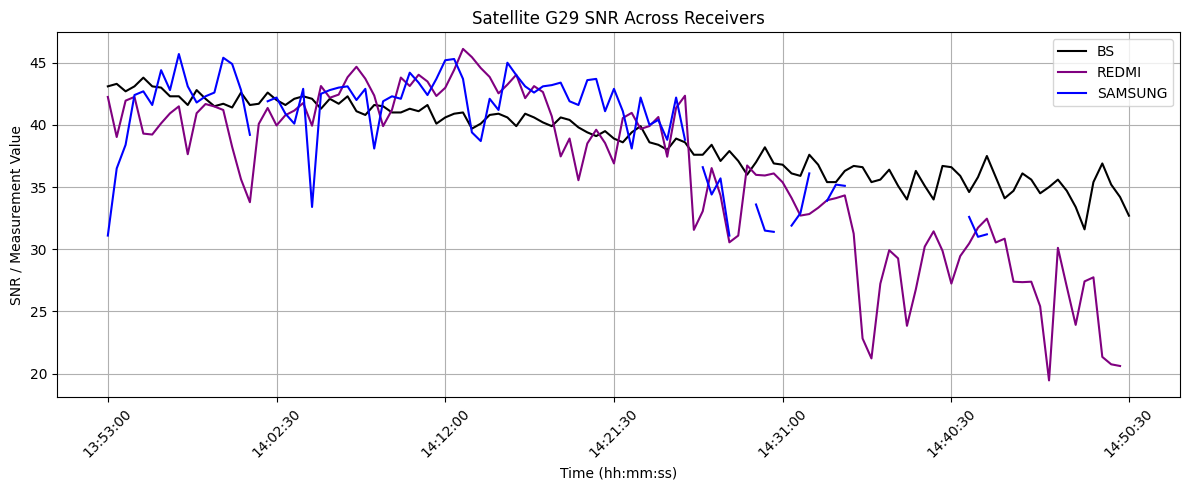

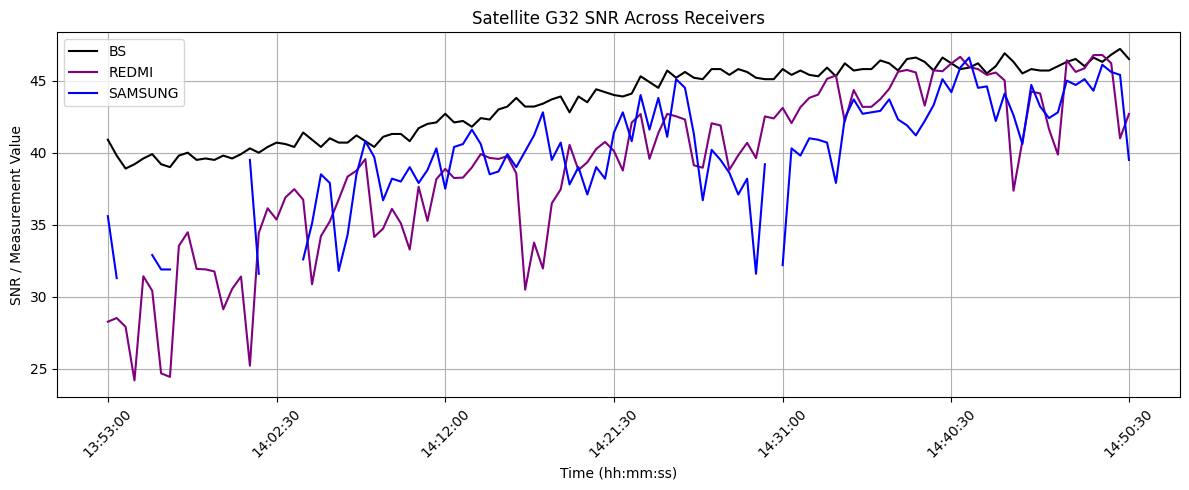

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Load the CSV file
df = pd.read_csv("/content/data_for_snr.csv")

# Step 2: Convert Timestamp to datetime format
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# Step 3: Extract hh:mm:ss format for plotting
df["Time_HMS"] = df["Timestamp"].dt.strftime("%H:%M:%S")

# Step 4: Define satellites and receiver color mapping
satellites = ['G18','G10', 'G15', 'G23', 'G24', 'G27', 'G29', 'G32']
receiver_colors = {
    "BS": "black",
    "REDMI": "purple",
    "SAMSUNG": "blue",

}
receivers = list(receiver_colors.keys())

# Step 5: Plot each satellite across available receivers
for sat in satellites:
    plt.figure(figsize=(12, 5))
    has_data = False  # To check if any receiver data exists for this satellite

    for rec in receivers:
        col_name = f"{sat}_{rec}"
        if col_name in df.columns:
            plt.plot(df["Time_HMS"], df[col_name], label=rec, color=receiver_colors[rec])
            has_data = True

    if has_data:
        # Pick ~7 evenly spaced ticks on the x-axis
        total_points = len(df["Time_HMS"])
        num_ticks = min(7, total_points)
        tick_indices = np.linspace(0, total_points - 1, num=num_ticks, dtype=int)
        tick_labels = df["Time_HMS"].iloc[tick_indices]

        plt.title(f"Satellite {sat} SNR Across Receivers")
        plt.xlabel("Time (hh:mm:ss)")
        plt.ylabel("SNR / Measurement Value")
        plt.xticks(ticks=tick_indices, labels=tick_labels, rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for satellite {sat}. Skipping plot.")
